In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution() 
# from tf import keras
# import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import numpy as np
import os
from train import parse_config, get_features
from eval import makeRoc, plot_confusion_matrix
from constraints import ZeroSomeWeights
from quantized_layers import Clip, BinaryDense, TernaryDense, QuantizedDense
from models import binary_tanh, ternary_tanh, quantized_relu
import yaml
from sklearn.metrics import confusion_matrix
import tkinter
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [2]:
# get data
data_path = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_truth.z'
f = h5py.File(data_path, 'r')
treeArray = f['t_allpar_new'][()]
print(treeArray.dtype.names)
print(treeArray.shape)

('j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_undef')
(986806,)


In [3]:
# get configuration
import yaml
config_file = "train_config_threelayer.yml"
config = open(config_file, 'r')
yamlConfig = yaml.load(config, Loader=yaml.FullLoader)
print(yamlConfig)

{'Inputs': ['j_zlogz', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_mmdt', 'j_multiplicity'], 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t'], 'KerasModel': 'three_layer_model', 'KerasModelRetrain': 'three_layer_model_constraint', 'KerasLoss': 'categorical_crossentropy', 'L1Reg': 0.0001, 'NormalizeInputs': 1, 'InputType': 'Dense'}


In [4]:
features = yamlConfig['Inputs']
labels = yamlConfig['Labels']

In [5]:
# convert to dataframe 
features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
features_labels_df = features_labels_df.drop_duplicates()
features_df = features_labels_df[features]
labels_df = features_labels_df[labels]

In [6]:
# Convert to numpy array 
features_val = features_df.values
labels_val = labels_df.values   
# print(features_val)
# print(labels_val)

In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2, random_state=42)

In [8]:
scaler = preprocessing.StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

In [9]:
#from models import three_layer_model
import models
model = getattr(models, yamlConfig['KerasModel']) 

In [10]:
from keras.layers import Input
keras_model = model(Input(shape=X_train_val.shape[1:]), y_train_val.shape[1], l1Reg=yamlConfig['L1Reg'] )

/Users/butterchicken/research/testingMLmodels/models.py:68: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="lecun_uniform", name="fc1_relu", kernel_regularizer=<keras.reg...)`
  name='fc1_relu', W_regularizer=l1(l1Reg))(Inputs)
/Users/butterchicken/research/testingMLmodels/models.py:70: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="lecun_uniform", name="fc2_relu", kernel_regularizer=<keras.reg...)`
  name='fc2_relu', W_regularizer=l1(l1Reg))(x)
/Users/butterchicken/research/testingMLmodels/models.py:72: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="lecun_uniform", name="fc3_relu", kernel_regularizer=<keras.reg...)`
  name='fc3_relu', W_regularizer=l1(l1Reg))(x)
/Users/butterchicken/research/testingMLmodels/models.py:74: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="softma

In [11]:
# compile model
from keras.optimizers import Adam, Nadam
startlearningrate=0.0001
adam = Adam(lr=startlearningrate)
keras_model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])

In [12]:
from callbacks import all_callbacks
callbacks=all_callbacks(stop_patience=1000, 
                            lr_factor=0.5,
                            lr_patience=10,
                            lr_epsilon=0.000001, 
                            lr_cooldown=2, 
                            lr_minimum=0.0000001,
                            outputDir='/Users/butterchicken/research/testingMLmodels/output')

/Users/butterchicken/opt/anaconda2/envs/research/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [13]:
keras_model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100, 
                validation_split = 0.25, shuffle = True)

Train on 592083 samples, validate on 197361 samples
Epoch 1/100
592083/592083 [==============================] - 2s 4us/step - loss: 1.3433 - accuracy: 0.5115 - val_loss: 1.1348 - val_accuracy: 0.6218
Epoch 2/100
592083/592083 [==============================] - 2s 3us/step - loss: 1.0598 - accuracy: 0.6522 - val_loss: 0.9987 - val_accuracy: 0.6770
Epoch 3/100
592083/592083 [==============================] - 2s 3us/step - loss: 0.9626 - accuracy: 0.6908 - val_loss: 0.9297 - val_accuracy: 0.7022
Epoch 4/100
592083/592083 [==============================] - 2s 3us/step - loss: 0.9089 - accuracy: 0.7075 - val_loss: 0.8901 - val_accuracy: 0.7132
Epoch 5/100
592083/592083 [==============================] - 2s 3us/step - loss: 0.8797 - accuracy: 0.7148 - val_loss: 0.8695 - val_accuracy: 0.7182
Epoch 6/100
592083/592083 [==============================] - 2s 3us/step - loss: 0.8641 - accuracy: 0.7188 - val_loss: 0.8571 - val_accuracy: 0.7220
Epoch 7/100
592083/592083 [===========================

592083/592083 [==============================] - 2s 3us/step - loss: 0.7660 - accuracy: 0.7445 - val_loss: 0.7640 - val_accuracy: 0.7445
Epoch 56/100
592083/592083 [==============================] - 2s 3us/step - loss: 0.7654 - accuracy: 0.7446 - val_loss: 0.7634 - val_accuracy: 0.7445
Epoch 57/100
592083/592083 [==============================] - 2s 3us/step - loss: 0.7649 - accuracy: 0.7448 - val_loss: 0.7636 - val_accuracy: 0.7444
Epoch 58/100
592083/592083 [==============================] - 2s 3us/step - loss: 0.7645 - accuracy: 0.7447 - val_loss: 0.7623 - val_accuracy: 0.7449
Epoch 59/100
592083/592083 [==============================] - 2s 3us/step - loss: 0.7639 - accuracy: 0.7448 - val_loss: 0.7617 - val_accuracy: 0.7447
Epoch 60/100
592083/592083 [==============================] - 2s 3us/step - loss: 0.7634 - accuracy: 0.7451 - val_loss: 0.7615 - val_accuracy: 0.7449
Epoch 61/100
592083/592083 [==============================] - 2s 3us/step - loss: 0.7629 - accuracy: 0.7452 - val

In [14]:
keras_model.evaluate(X_test,y_test,verbose=0)

[0.7500925313290756, 0.747585654258728]

In [15]:
tf.executing_eagerly() 

True

In [16]:
keras_model.save("re3layer.h5")

In [17]:
model_json = keras_model.to_json()
with open("3layermodel.json", "w") as json_file:
    json_file.write(model_json)
keras_model.save_weights("3layermodelweights.h5")
print("Saved model to disk")


AttributeError: 'function' object has no attribute 'save_weights'

In [18]:
from collections import namedtuple
import sys
N = namedtuple("options", "inputModel inputFile tree config jsonModel")
options = N(
    inputModel = 're3layer.h5',
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_threelayer.yml',
    jsonModel = '3layermodel.json'
)

In [19]:
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
print(yamlConfig)

{'Inputs': ['j_zlogz', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_mmdt', 'j_multiplicity'], 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t'], 'KerasModel': 'three_layer_model', 'KerasModelRetrain': 'three_layer_model_constraint', 'KerasLoss': 'categorical_crossentropy', 'L1Reg': 0.0001, 'NormalizeInputs': 1, 'InputType': 'Dense'}


In [20]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

/Users/butterchicken/research/testingMLmodels/train.py:33: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)


(986806,)
('j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_undef')


In [21]:
json_file = open(options.jsonModel, 'r')
model = json_file.read()
json_file.close()
model = model_from_json(model, custom_objects={'ZeroSomeWeights': ZeroSomeWeights,
                                                           'BinaryDense': BinaryDense,
                                                           'TernaryDense': TernaryDense,
                                                           'QuantizedDense': QuantizedDense,
                                                           'binary_tanh': binary_tanh,
                                                           'ternary_tanh': ternary_tanh,
                                                           'quantized_relu': quantized_relu,
                                                           'Clip': Clip})

In [22]:
model.load_weights(options.inputModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
fc1_relu (Dense)             (None, 64)                1088      
_________________________________________________________________
fc2_relu (Dense)             (None, 32)                2080      
_________________________________________________________________
fc3_relu (Dense)             (None, 32)                1056      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165       
Total params: 4,389
Trainable params: 4,389
Non-trainable params: 0
_________________________________________________________________


Plot ROC curve
in makeRoc()


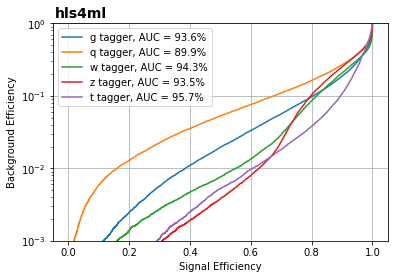

Plot confusion matrix


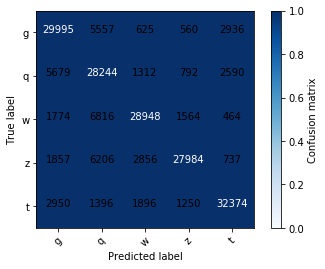

Plot normalized confusion matrix


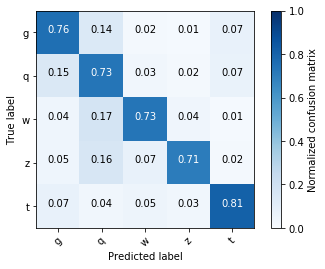

In [23]:
print("Plot ROC curve")
y_predict = makeRoc(X_test, labels, y_test, model)
plt.show()
# print(y_predict)

y_test_proba = y_test.argmax(axis=1)
y_predict_proba = y_predict.argmax(axis=1)

print("Plot confusion matrix")
# Compute non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test_proba, y_predict_proba)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[l.replace('j_','') for l in labels],
                          title='Confusion matrix')
# plt.show()
print("Plot normalized confusion matrix")

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[l.replace('j_','') for l in labels], normalize=True,
                          title='Normalized confusion matrix')
# plt.show()